In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import math # For radians in rose plot
from matplotlib.colors import ListedColormap
import plotly.graph_objects as go
import random
import subprocess
import json # Import json to load the stats file
import pandas as pd # Import pandas for DataFrame summary
from utilities import plot_fault_counts, plot_histogram, plot_rose_diagram, append_param_to_cmd, normalize, plot_fault_points

from tqdm import trange

---

---

# Data Generation

In [2]:
# ─── 0) User picks parameters ────────────────────────────────────────────
mask_mode    = 0 # 0 binary (0, 1) | 1 Multiclass (0, 1, 2), normal and inverse faults
num_pairs    = 20
cube_size    = 128
ricker_freq = (5, 35)      # Hz or (min, max)
seismic_noise = (0.1, 0.5)      # None | float | (min, max)
ricker_dt    = 0.002
wavelet_len  = 0.2        # s
num_gauss    = (2,10)     # int or (min, max)
num_faults = (0,4)       # int or (min, max) faults per cube
max_disp   = (75, 100)   # int or (min, max) max displacement magnitude per cube
strike     = (0,360)      # deg or (min, max) strike angle per fault
dip        = (35,80) # deg or (min, max) dip angle per fault
output_format = "dat" # npy, npz, or dat
train_split = 0.7 # 70% for training
val_split = 0.15 # 15% for validation

import os
import json
import random
import subprocess
from tqdm import tqdm

# ─── 1) Call your script (passing parameters from notebook variables) ─────────────────
script = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py"
base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output")

# Create output directory if it doesn't exist
os.makedirs(base_out, exist_ok=True)

print(f"Running script: {script}")
print(f"Output directory: {base_out}")

# Calculate the number of samples for each set
num_train = int(num_pairs * train_split)
num_val = int(num_pairs * val_split)
num_pred = num_pairs - num_train - num_val

# Construct the command
cmd = [
    "python", script,
    "--num-pairs",     str(num_pairs),
    "--size",          str(cube_size),
    "--dt",            str(ricker_dt),
    "--length",        str(wavelet_len),
    "--mask-mode",     str(mask_mode),
    "--format",        output_format,
    "--output-dir",    base_out,
    "--train-split",   str(train_split),
    "--val-split",     str(val_split),
    "--faults",        f"{num_faults[0]},{num_faults[1]}",
    "--max-disp",      f"{max_disp[0]},{max_disp[1]}",
    "--strike",        f"{strike[0]},{strike[1]}",
    "--dip",           f"{dip[0]},{dip[1]}",
    "--freq",          f"{ricker_freq[0]},{ricker_freq[1]}",
    "--num-gaussians", f"{num_gauss[0]},{num_gauss[1]}",
    "--noise",         f"{seismic_noise[0]},{seismic_noise[1]}",
]

# Run the command
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("Data generation successful!")
    print(result.stdout)
else:
    print("Data generation failed.")
    print(result.stderr)

# Data generation statistics
stats = {
    "total_pairs": num_pairs,
    "train_pairs": num_train,
    "validation_pairs": num_val,
    "prediction_pairs": num_pred,
}

# Save statistics to a JSON file
stats_file_path = os.path.join(base_out, "stats_data.json")
with open(stats_file_path, 'w') as f:
    json.dump(stats, f, indent=4)

print(f"Data generation complete. Statistics saved to {stats_file_path}")

Running script: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/synthDataGeneration.py
Output directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output
Data generation successful!
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/train
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/validation
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/prediction

Data split: 14 train, 3 validation, 3 prediction.

Starting data generation for 20 pairs...
Generating cube 1/20 (Assignment: train)...
Generating cube 2/20 (Assignment: train)...
Generating cube 3/20 (Assignment: train)...
Generating cube 4/20 (Assignment: train)...
Generating cube 5/20 (Assignment: train)...
Generating cube 6/20 (Assignment: validation)...
Generating cube 7/20 (Assignment: train)...
Generating cube 

In [3]:
# ─── 2) Run Data Generation Script ──────────────────────────────────────────────────────────────────────

# Construct the command to run the generation script
script = 'synthDataGeneration.py'
cmd = [
    'python',
    script,
    f'--num-pairs={num_pairs}',
    f'--format={output_format}',
    f'--output-dir={base_out}',
    f'--train-split={train_split}',
    f'--val-split={val_split}',
    f'--faults={num_faults[0]},{num_faults[1]}',
    f'--max-disp={max_disp[0]},{max_disp[1]}',
    f'--strike={strike[0]},{strike[1]}',
    f'--dip={dip[0]},{dip[1]}',
    f'--freq={ricker_freq[0]},{ricker_freq[1]}',
    f'--num-gaussians={num_gauss[0]},{num_gauss[1]}',
    f'--noise={seismic_noise[0]},{seismic_noise[1]}'
]

# Run the command
print(f"Running command: {' '.join(cmd)}")
result = subprocess.run(cmd, capture_output=True, text=True)

# Display the script's output
print("--- Script STDOUT ---")
print(result.stdout)
if result.stderr:
    print("--- Script STDERR ---")
    print(result.stderr)

# Verification check
# Check the total number of files created across all splits
total_files_generated = 0
for split in ['train', 'validation', 'prediction']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len(os.listdir(seis_dir))

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs.")


Running command: python synthDataGeneration.py --num-pairs=20 --format=dat --output-dir=/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output --train-split=0.7 --val-split=0.15 --faults=0,4 --max-disp=75,100 --strike=0,360 --dip=35,80 --freq=5,35 --num-gaussians=2,10 --noise=0.1,0.5
--- Script STDOUT ---
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/train
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/validation
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/prediction

Data split: 14 train, 3 validation, 3 prediction.

Starting data generation for 20 pairs...
Generating cube 1/20 (Assignment: prediction)...
Generating cube 2/20 (Assignment: train)...
Generating cube 3/20 (Assignment: prediction)...
Generating cube 4/20 (Assignment: validation)...
Generating cube 5/20 (Assignment: validation)..

In [ ]:
# Append parameters that can be fixed values or ranges
def append_param_to_cmd(cmd_list, arg_name, value):
    if value is not None:
        if isinstance(value, tuple):
            cmd_list += [f"--{arg_name}", f"{value[0]},{value[1]}"]
        else:
            cmd_list += [f"--{arg_name}", str(value)]

append_param_to_cmd(cmd, "freq", ricker_freq)
append_param_to_cmd(cmd, "num-gaussians", num_gauss)
append_param_to_cmd(cmd, "noise", seismic_noise)
append_param_to_cmd(cmd, "faults", num_faults)
append_param_to_cmd(cmd, "max-disp", max_disp)
append_param_to_cmd(cmd, "strike", strike)
append_param_to_cmd(cmd, "dip", dip)

Example seismic data path: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/train/seis
Example mask data path: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/train/fault
Statistics file path: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/statistics.json



In [5]:
# Define which data split to visualize: 'train', 'validation', 'prediction', or 'full'
data_split_to_visualize = 'train'

print("\nCommand to run:")
print(" ".join(cmd)) # Print the corrected command
print("\nRunning subprocess...")

# run and capture output
# check=False allows inspection of returncode without raising exception immediately
result = subprocess.run(cmd, capture_output=True, text=True, check=False)
print("=== STDOUT ===\n", result.stdout)
print("=== STDERR ===\n", result.stderr)

if result.returncode != 0:
    print(f"Error: Script exited with return code {result.returncode}")
    # Optionally print more context or raise error
    # raise subprocess.CalledProcessError(result.returncode, cmd, output=result.stdout, stderr=result.stderr)
    # Exit this cell or notebook execution if script failed critically?
    # For now, just print error and continue, assuming stats file might still be partially saved
else:
    print("Script finished successfully.")

# Check if the expected number of files were generated
total_files_generated = 0
for split in ['train', 'validation', 'prediction']:
    seis_dir = os.path.join(base_out, split, 'seis')
    if os.path.exists(seis_dir):
        total_files_generated += len([f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat"))])

if total_files_generated != num_pairs:
    print(f"\nWarning: Mismatch in generated files ({total_files_generated}) and requested pairs ({num_pairs}). Check script output.")
else:
    print(f"\nSuccessfully generated {total_files_generated} file pairs across all splits.")


Command to run:
python synthDataGeneration.py --num-pairs=20 --format=dat --output-dir=/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output --train-split=0.7 --val-split=0.15 --faults=0,4 --max-disp=75,100 --strike=0,360 --dip=35,80 --freq=5,35 --num-gaussians=2,10 --noise=0.1,0.5 --freq 5,35 --num-gaussians 2,10 --noise 0.1,0.5 --faults 0,4 --max-disp 75,100 --strike 0,360 --dip 35,80

Running subprocess...
=== STDOUT ===
 Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/train
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/validation
Cleaned directory: /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/prediction

Data split: 14 train, 3 validation, 3 prediction.

Starting data generation for 20 pairs...
Generating cube 1/20 (Assignment: train)...
Generating cube 2/20 (Assignment: train)...
Generating cube 3/20 (Assi

In [7]:
# ─── 2) Load generated data and statistics ───────────────────────────────────────────────────────

# Define the base output directory
base_out = os.path.expanduser("/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output")

# Define the splits and their expected number of files
splits = {
    "train": num_train,
    "validation": num_val,
    "prediction": num_pred
}

# Check if the expected number of files were generated for each split
for split, expected_files in splits.items():
    seis_dir = os.path.join(base_out, split, "seis")
    fault_dir = os.path.join(base_out, split, "fault")

    if os.path.exists(seis_dir):
        files = sorted(f for f in os.listdir(seis_dir) if f.endswith((".npy", ".npz", ".dat")))
        n_files = len(files)
        if n_files != expected_files:
            print(f"Warning: Mismatch in generated files for '{split}' split. Expected {expected_files}, found {n_files} in {seis_dir}")
    else:
        print(f"Warning: Seismic output directory not found for '{split}' split: {seis_dir}")

    if not os.path.exists(fault_dir):
        print(f"Warning: Fault output directory not found for '{split}' split: {fault_dir}")

# Load the statistics files
stats_data = {}
for split in splits.keys():
    stats_file_path = os.path.join(base_out, f"statistics_{split}.json")
    if os.path.exists(stats_file_path):
        with open(stats_file_path, 'r') as f:
            stats_data[split] = json.load(f)
            print(f"Successfully loaded statistics for '{split}' split.")
    else:
        print(f"Warning: Statistics file not found for '{split}' split: {stats_file_path}")

# Load the full statistics file
full_stats_path = os.path.join(base_out, "statistics_full.json")
if os.path.exists(full_stats_path):
    with open(full_stats_path, 'r') as f:
        full_stats = json.load(f)
        print("Successfully loaded full statistics.")
else:
    print(f"Warning: Full statistics file not found: {full_stats_path}")

Successfully loaded statistics for 'train' split.
Successfully loaded statistics for 'validation' split.
Successfully loaded statistics for 'prediction' split.
Successfully loaded full statistics.


In [8]:
# Load all statistics: full, prediction, train, and validation
stats_files = {
    "full": os.path.join(base_out, "statistics_full.json"),
    "train": os.path.join(base_out, "statistics_train.json"),
    "validation": os.path.join(base_out, "statistics_validation.json"),
    "prediction": os.path.join(base_out, "statistics_prediction.json"),
}

all_stats_data = {}
for split, path in stats_files.items():
    if os.path.exists(path):
        try:
            with open(path, 'r') as f:
                all_stats_data[split] = json.load(f)
            print(f"Loaded statistics for '{split}' from {path}")
        except Exception as e:
            print(f"Error loading statistics for '{split}': {e}")
            all_stats_data[split] = None
    else:
        print(f"Statistics file not found for '{split}': {path}")
        all_stats_data[split] = None

Loaded statistics for 'full' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/statistics_full.json
Loaded statistics for 'train' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/statistics_train.json
Loaded statistics for 'validation' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/statistics_validation.json
Loaded statistics for 'prediction' from /Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output/statistics_prediction.json



--- Displaying Statistics and Plots for full data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count  20.000000    20.000000      20.000000             20.000000   
mean   17.920498     0.337659       5.700000              2.150000   
std    10.769587     0.107338       2.178846              1.565248   
min     5.922365     0.128067       2.000000              0.000000   
25%     9.273846     0.283604       4.000000              0.750000   
50%    14.948493     0.352585       6.000000              2.500000   
75%    28.767247     0.416645       7.000000              3.250000   
max    34.955839     0.490922      10.000000              4.000000   

       max_disp_used  
count      20.000000  
mean       87.800000  
std         6.677535  
min        77.000000  
25%        82.000000  
50%        88.000000  
75%        92.500000  
max        99.000000  


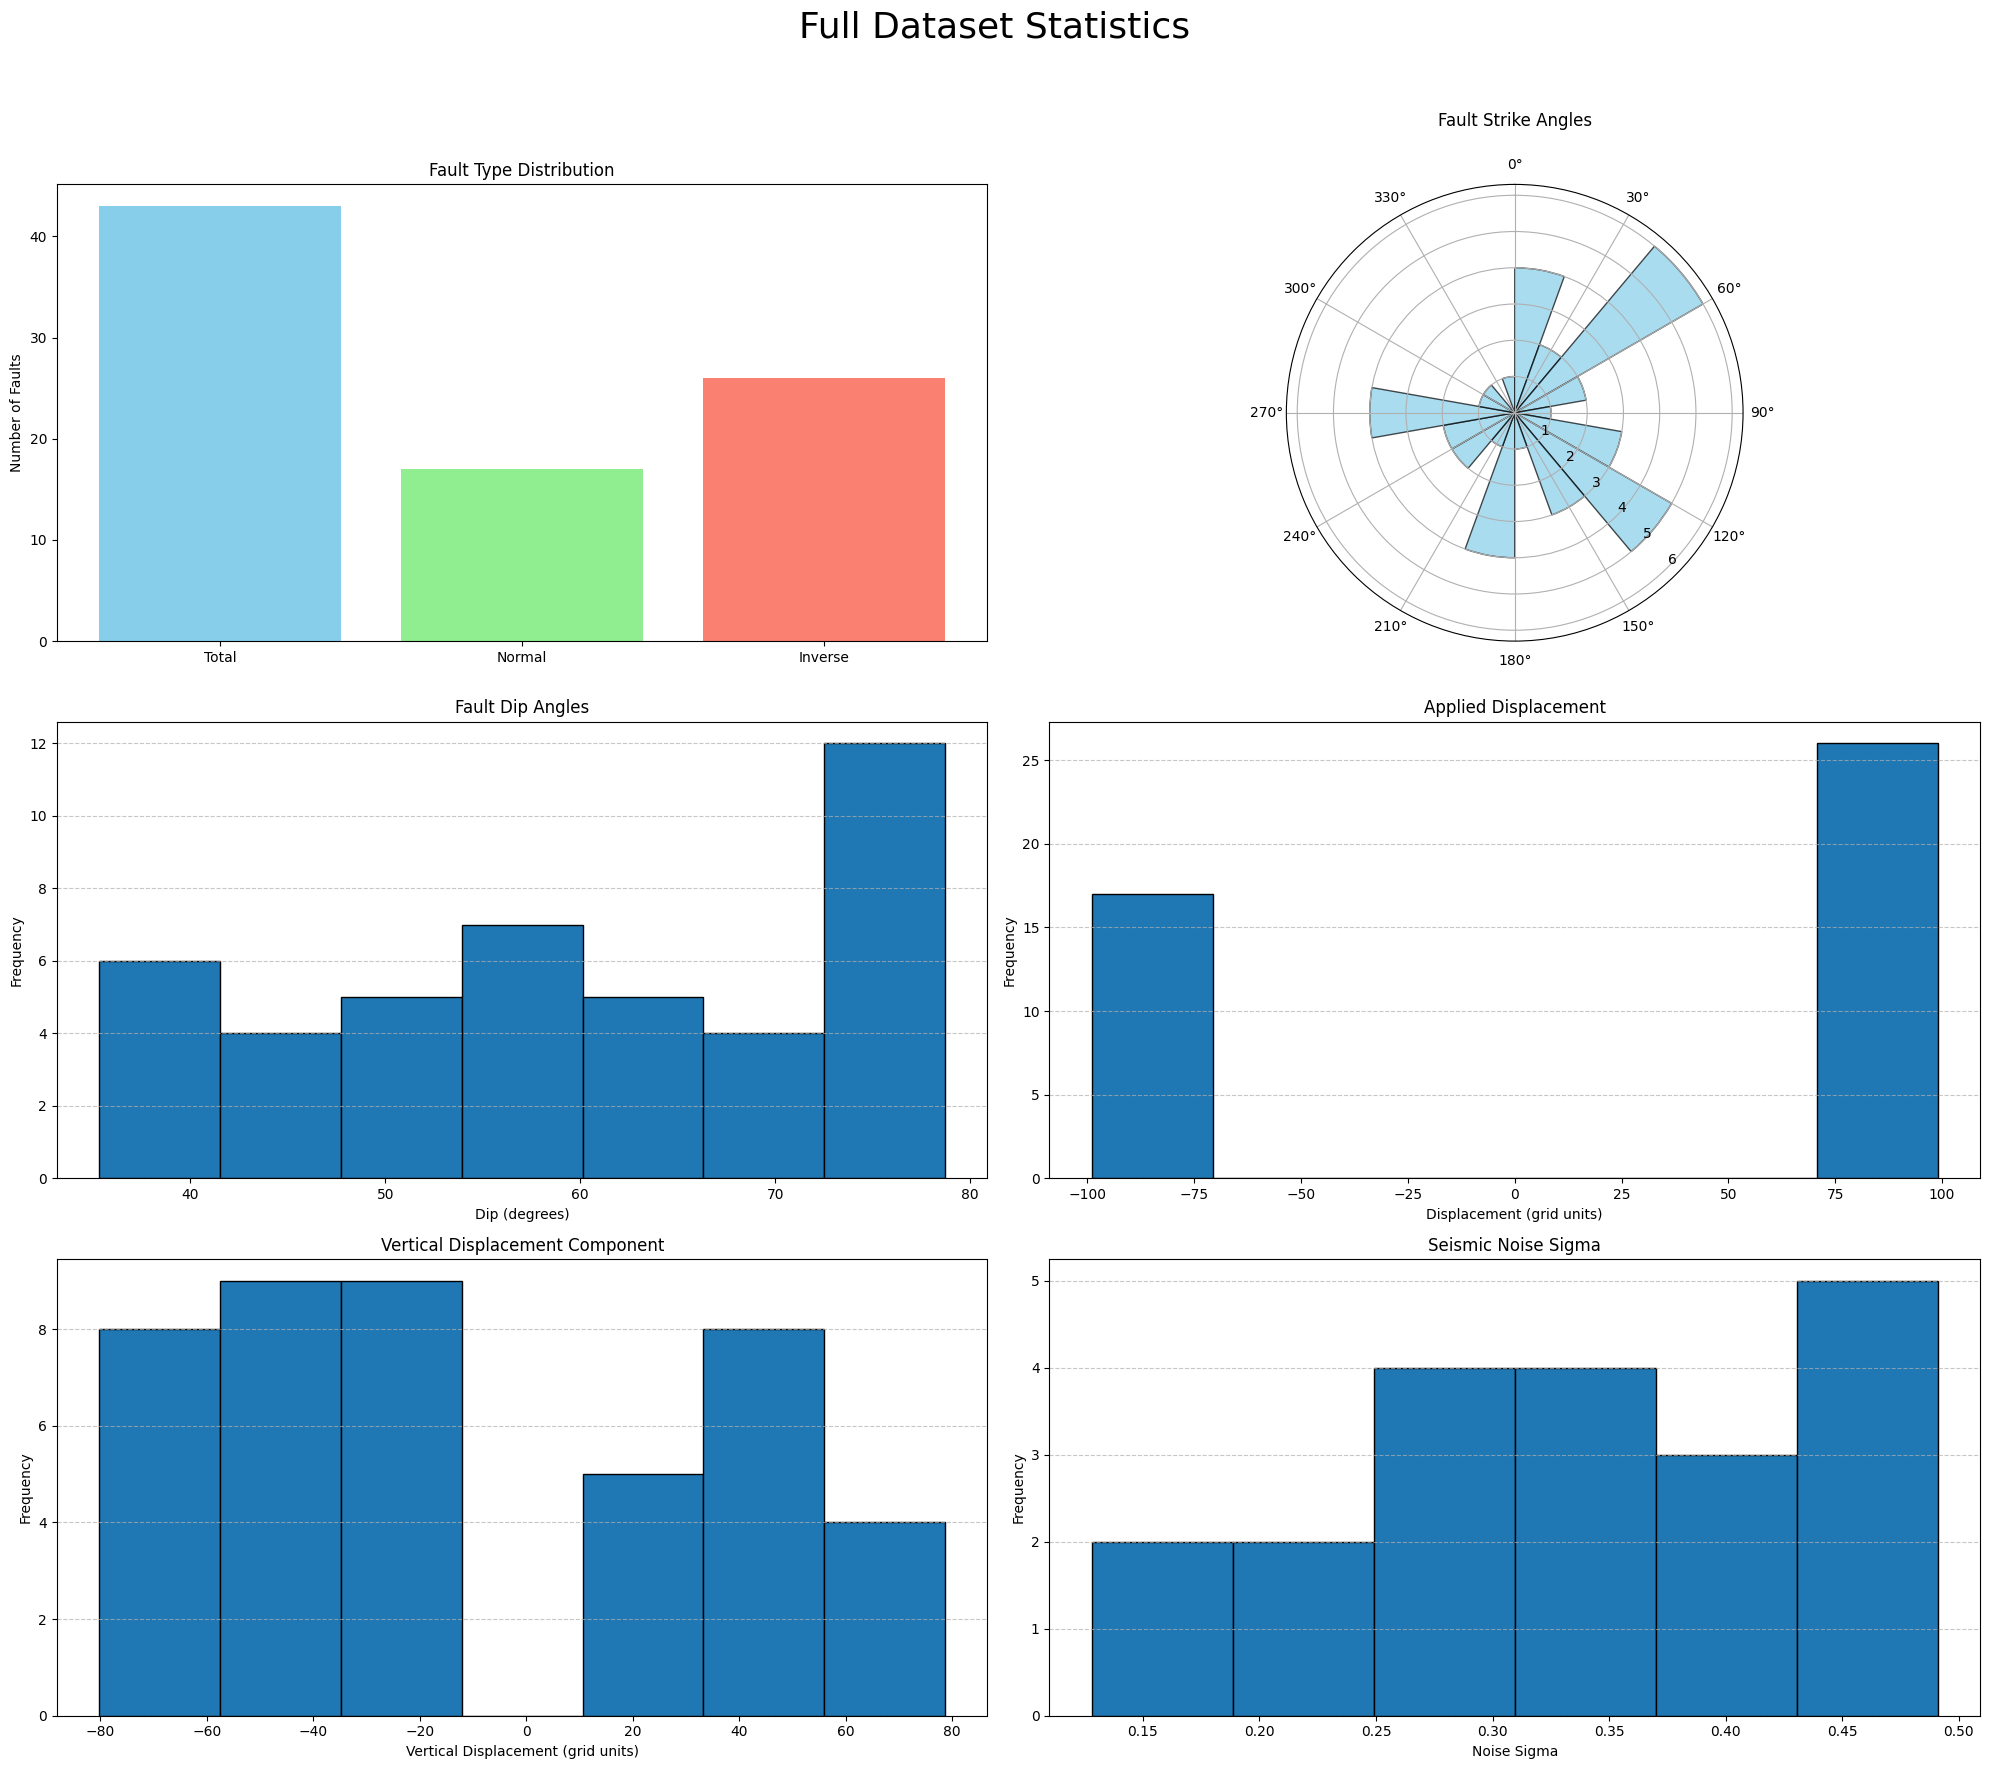


--- Displaying Statistics and Plots for train data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count  14.000000    14.000000      14.000000             14.000000   
mean   17.895033     0.312572       6.428571              1.928571   
std    10.899300     0.116086       2.064882              1.730464   
min     6.036139     0.128067       3.000000              0.000000   
25%     8.349194     0.241060       4.500000              0.000000   
50%    15.279300     0.299007       7.000000              2.000000   
75%    25.803833     0.425241       7.750000              3.750000   
max    34.955839     0.463999      10.000000              4.000000   

       max_disp_used  
count      14.000000  
mean       88.142857  
std         6.538138  
min        77.000000  
25%        82.250000  
50%        89.000000  
75%        91.750000  
max        99.000000  


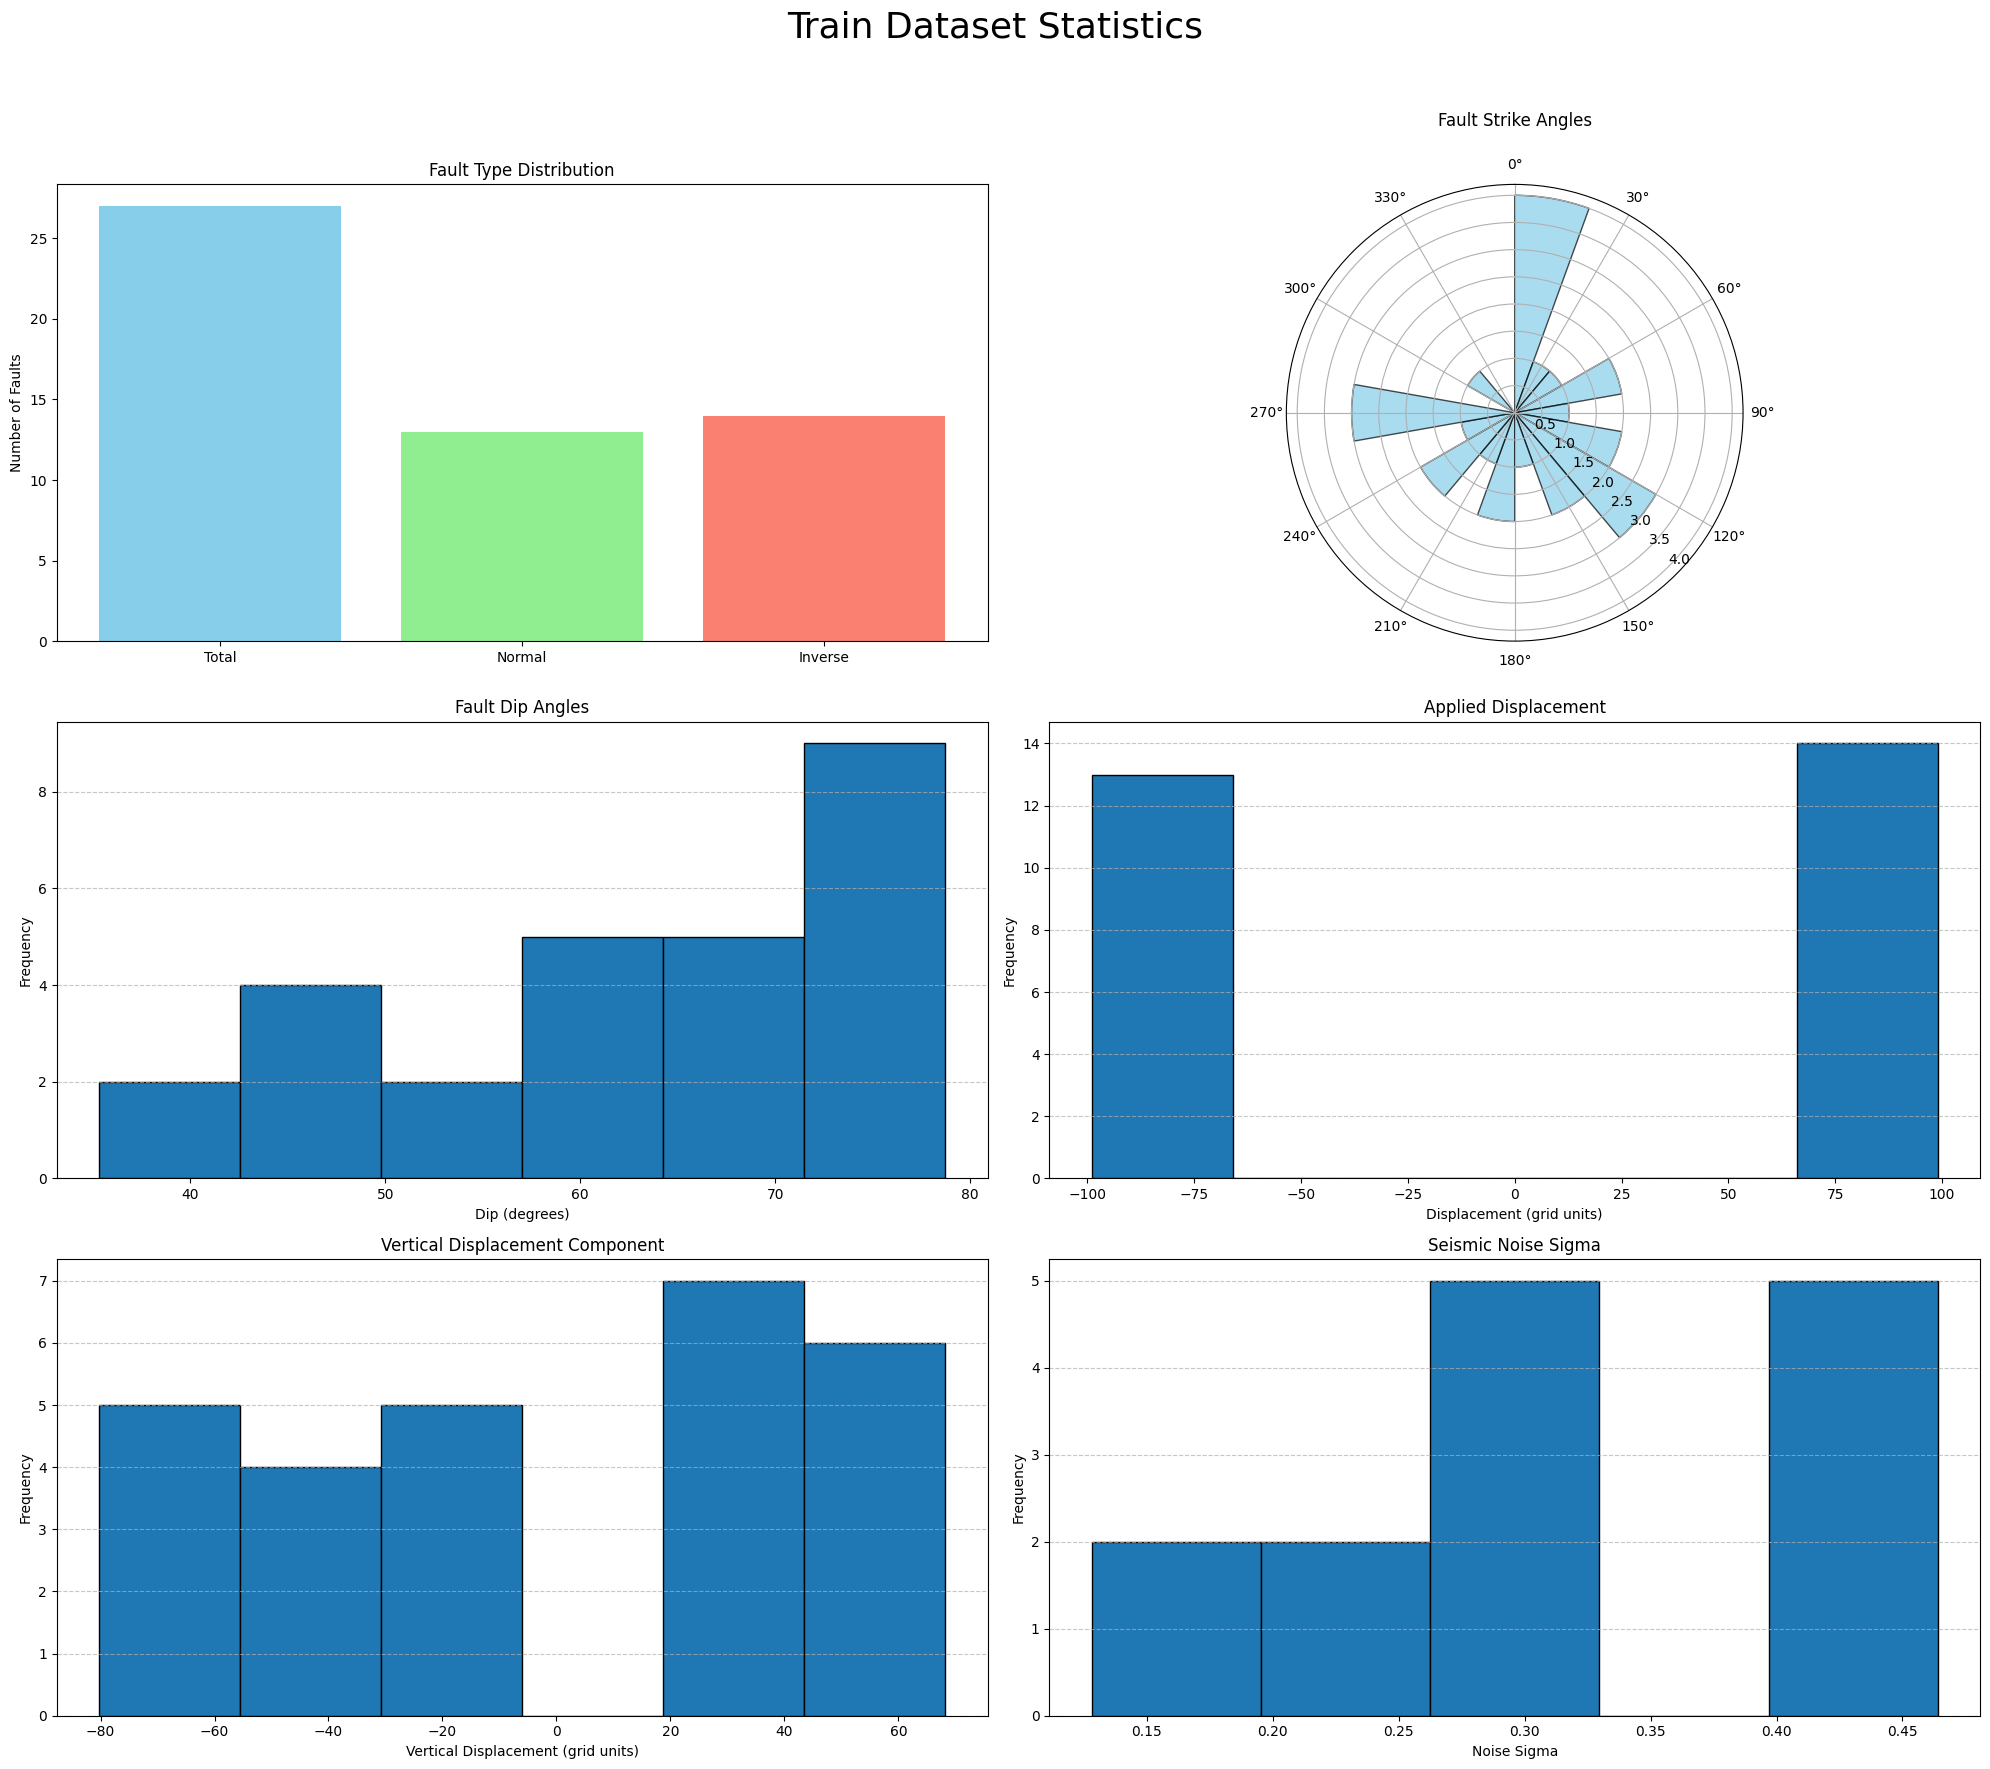


--- Displaying Statistics and Plots for validation data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count   3.000000     3.000000            3.0                   3.0   
mean   17.227247     0.402236            4.0                   2.0   
std    12.553203     0.076896            1.0                   1.0   
min     9.746602     0.354148            3.0                   1.0   
25%     9.980915     0.357893            3.5                   1.5   
50%    10.215227     0.361638            4.0                   2.0   
75%    20.967570     0.426280            4.5                   2.5   
max    31.719913     0.490922            5.0                   3.0   

       max_disp_used  
count       3.000000  
mean       90.000000  
std        10.440307  
min        78.000000  
25%        86.500000  
50%        95.000000  
75%        96.000000  
max        97.000000  


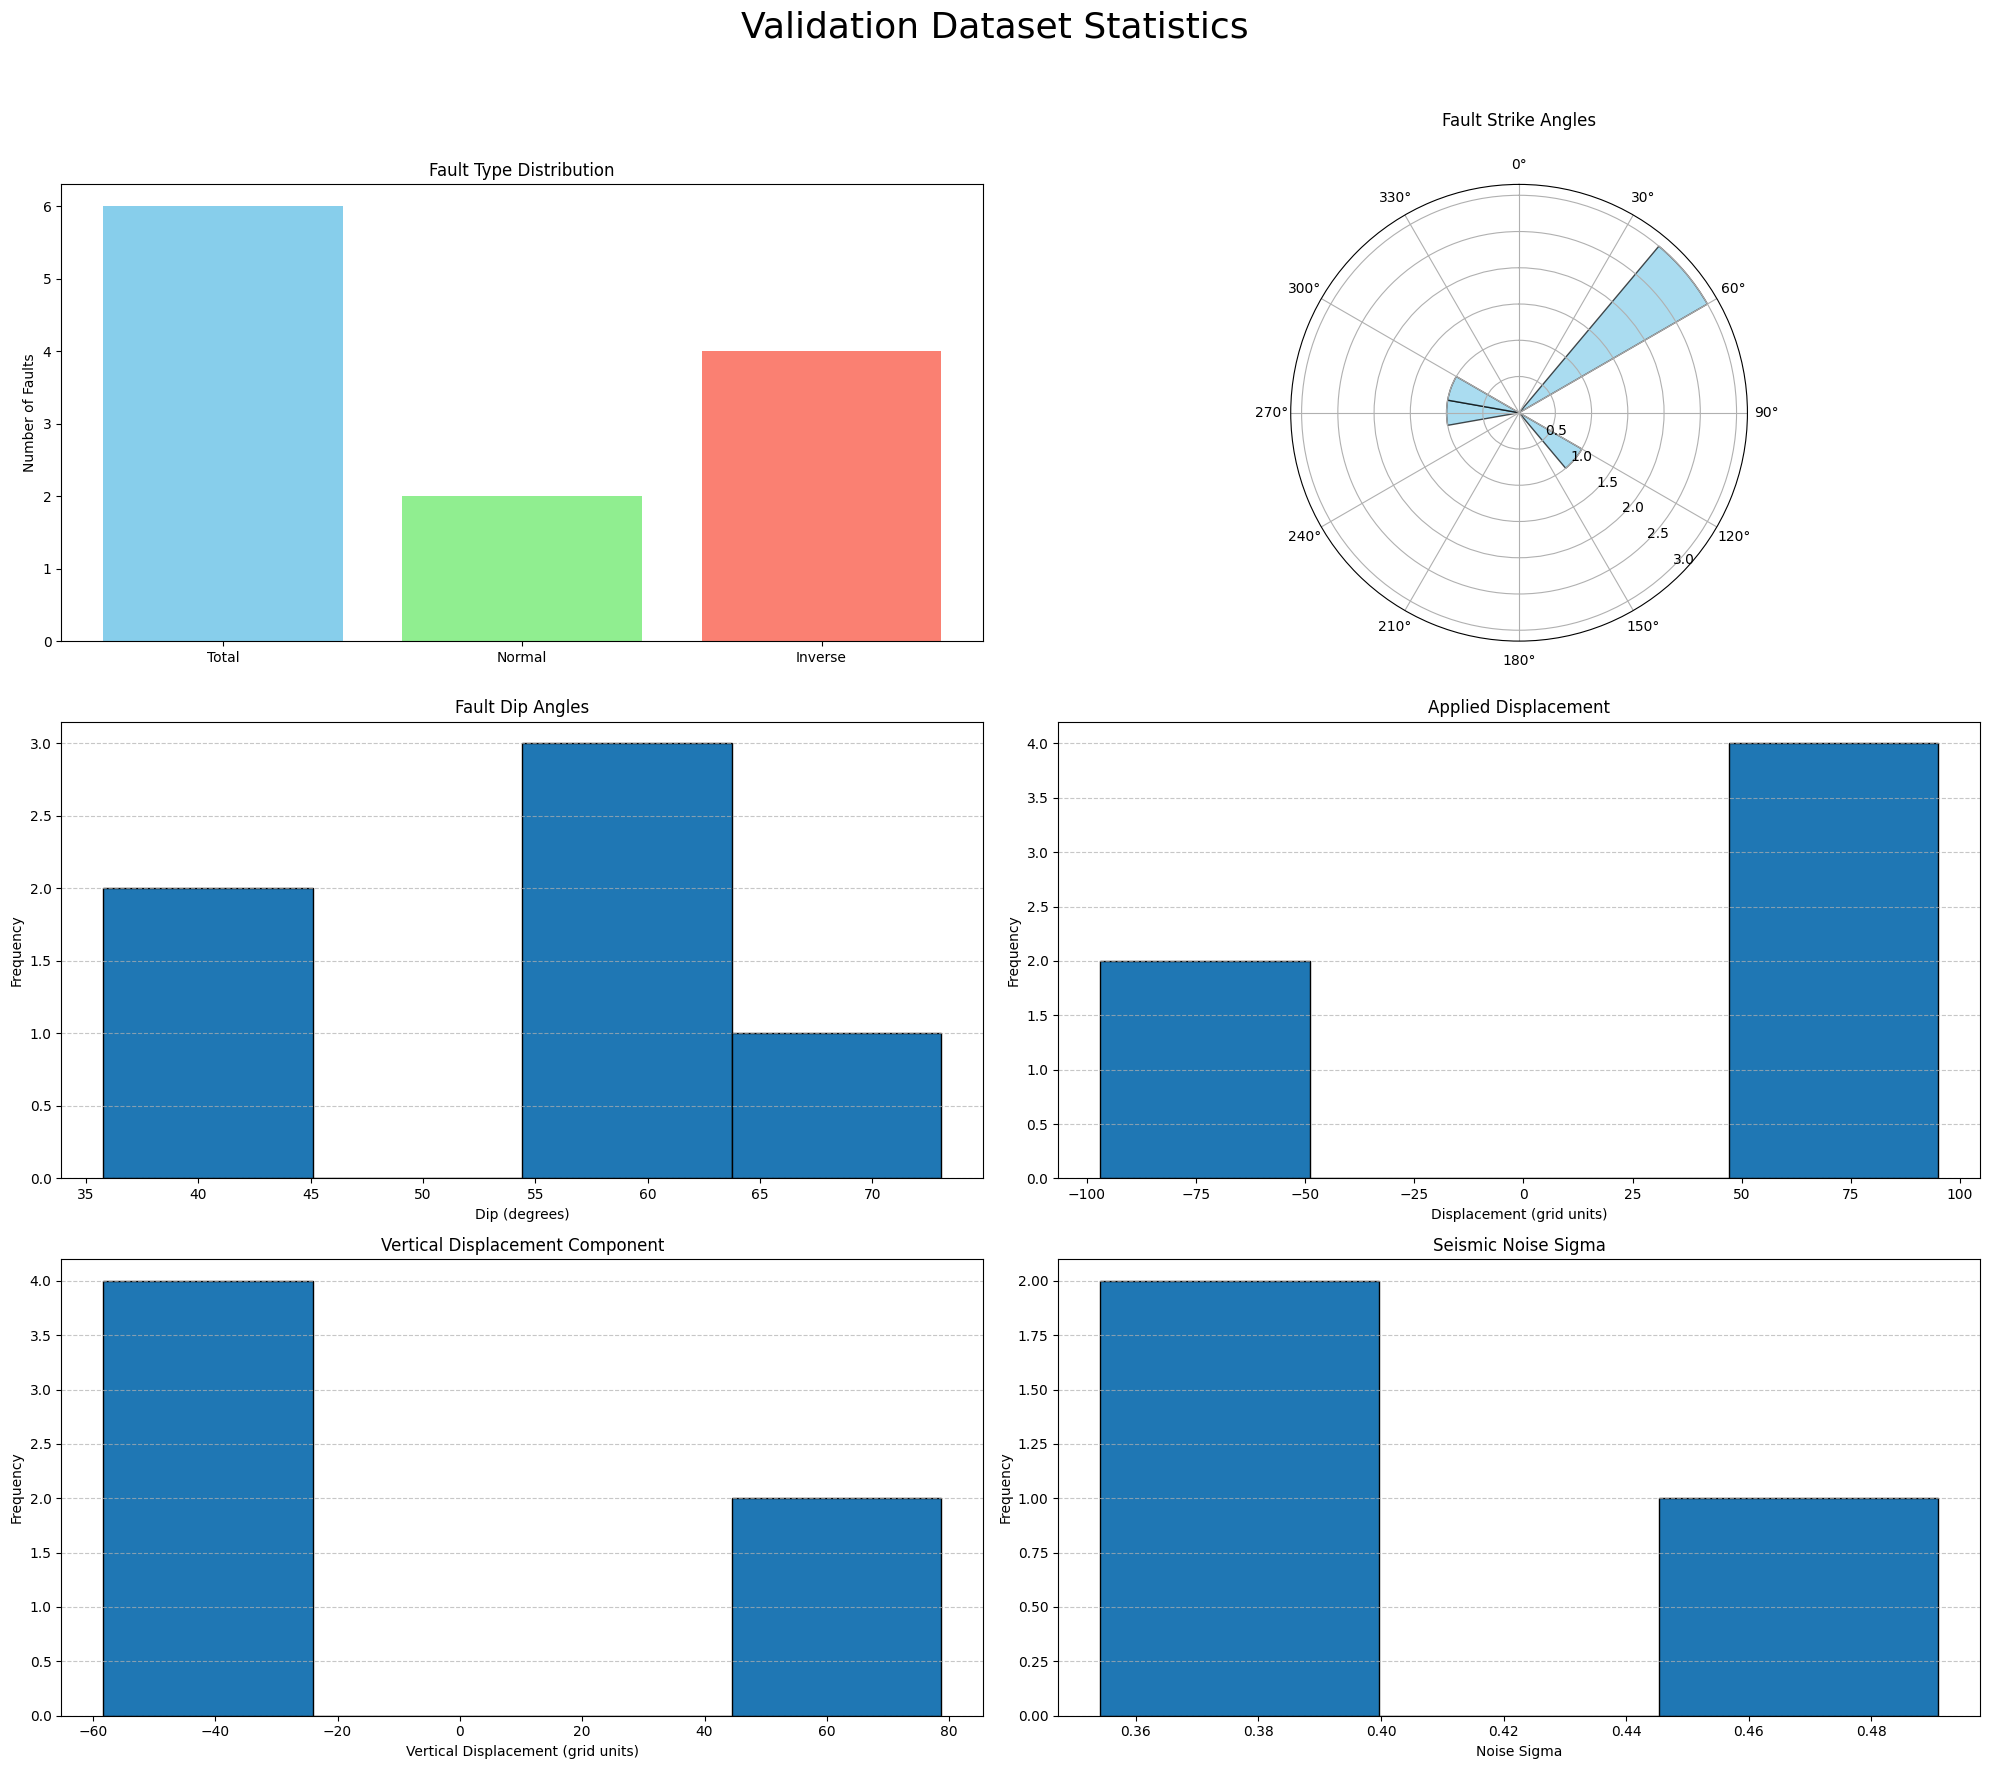


--- Displaying Statistics and Plots for prediction data ---

Cube Generation Parameter Summary:
            freq  noise_sigma  num_gaussians  num_faults_generated  \
count   3.000000     3.000000            3.0              3.000000   
mean   18.732583     0.390157            4.0              3.333333   
std    13.053152     0.033940            2.0              0.577350   
min     5.922365     0.351021            2.0              3.000000   
25%    12.090969     0.379478            3.0              3.000000   
50%    18.259572     0.407936            4.0              3.000000   
75%    25.137691     0.409725            5.0              3.500000   
max    32.015810     0.411514            6.0              4.000000   

       max_disp_used  
count       3.000000  
mean       84.000000  
std         2.645751  
min        82.000000  
25%        82.500000  
50%        83.000000  
75%        85.000000  
max        87.000000  


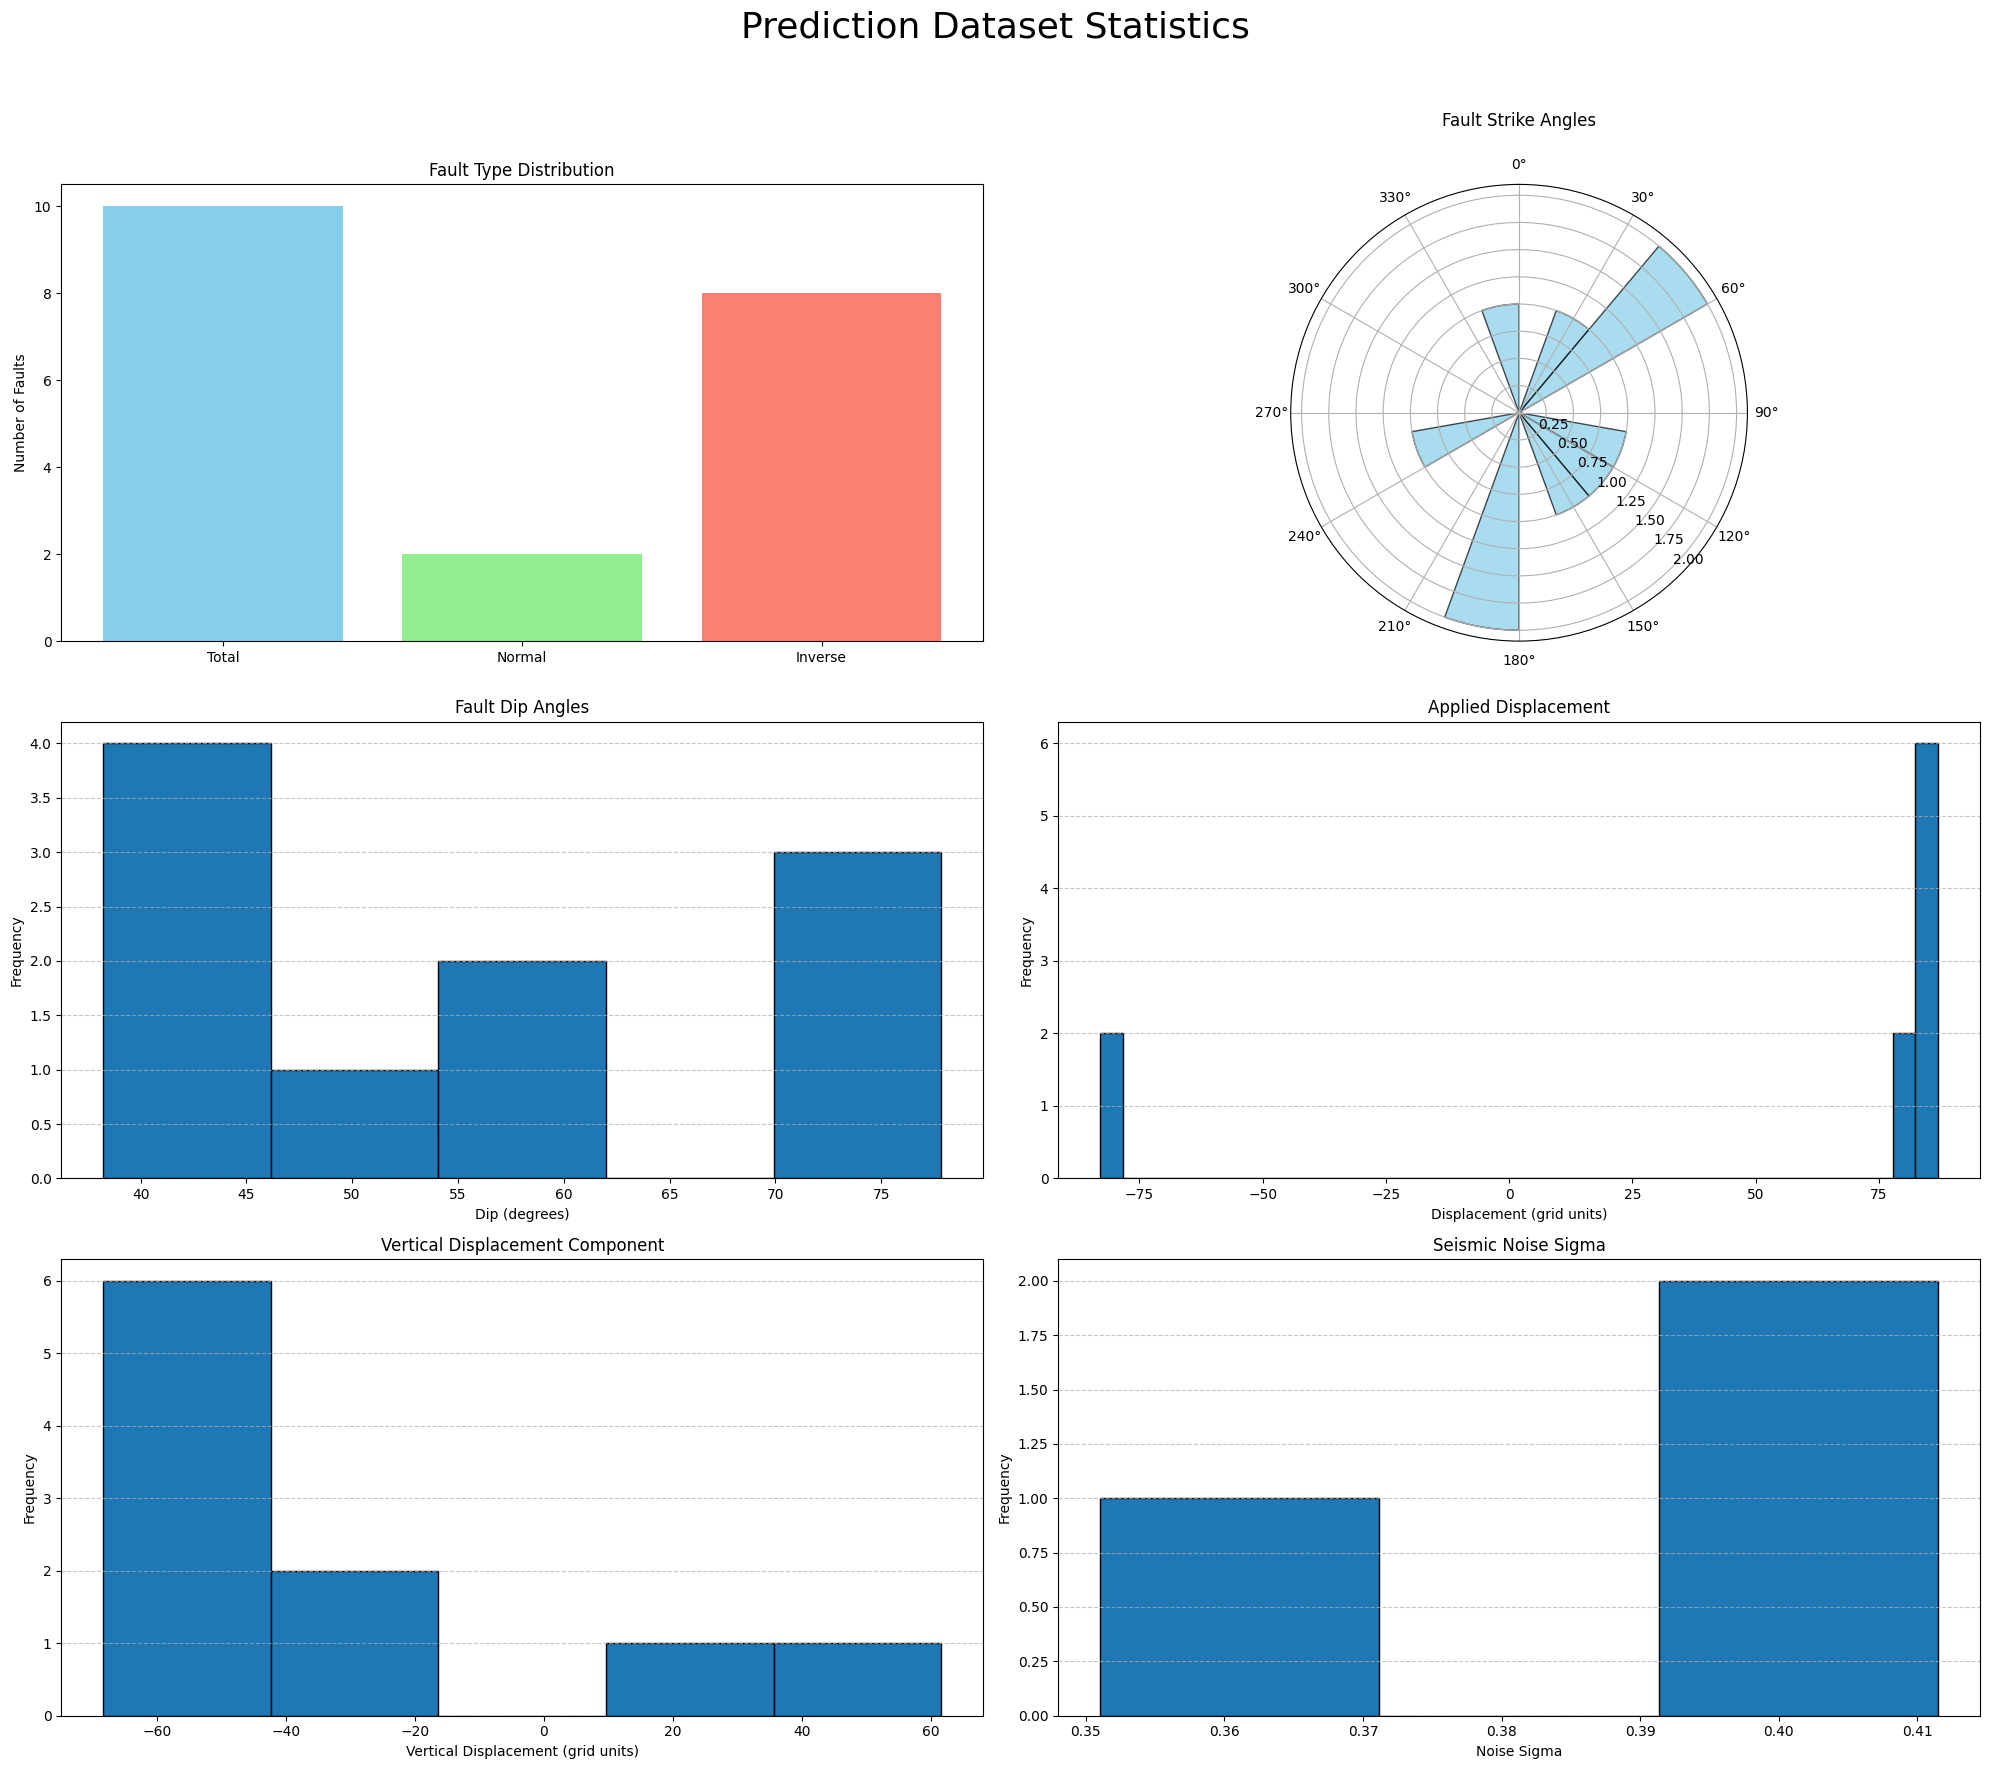

In [9]:
# ─── 3) Display Statistics and Plots for All Splits Individually ──────────────────────────────

for split_name in ['full', 'train', 'validation', 'prediction']:
    stats = all_stats_data.get(split_name)
    print(f"\n--- Displaying Statistics and Plots for {split_name} data ---")

    if not stats or 'cube_level_params' not in stats or 'all_fault_params' not in stats:
        print(f"No statistics available for '{split_name}' split.")
        continue

    # Extract parameters for the current split
    cube_level_params = stats['cube_level_params']
    all_fault_params = stats['all_fault_params']

    # Create a summary DataFrame
    df = pd.DataFrame(cube_level_params)
    print("\nCube Generation Parameter Summary:")
    print(df.describe())

    # --- Generate and Display Plots ---
    if not all_fault_params:
        print("\nNo fault parameters to plot for this split.")
        continue

    # Extract fault-specific data for plotting
    strikes = [f['strike'] for f in all_fault_params]
    dips = [f['dip'] for f in all_fault_params]
    displacements = [f['applied_disp_signed'] for f in all_fault_params]
    vertical_displacements = [f['vertical_disp_component'] for f in all_fault_params]
    noise_sigmas = [p.get('noise_sigma') for p in cube_level_params]

    # Create a figure with a grid of subplots
    fig = plt.figure(figsize=(20, 18))
    fig.suptitle(f"{split_name.capitalize()} Dataset Statistics", fontsize=26)
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1])

    # Plot Fault Counts
    ax1 = fig.add_subplot(gs[0, 0])
    normal_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Normal')
    inverse_count = sum(1 for f in all_fault_params if f['fault_type'] == 'Inverse')
    ax1.bar(['Total', 'Normal', 'Inverse'], [len(all_fault_params), normal_count, inverse_count], color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_title(f'Fault Type Distribution')
    ax1.set_ylabel('Number of Faults')

    # Plot Strike Rose Diagram
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    if strikes:
        plot_rose_diagram(strikes, ax=ax2, title='Fault Strike Angles')

    # Plot Dip Histogram
    ax3 = fig.add_subplot(gs[1, 0])
    if dips:
        plot_histogram(dips, ax=ax3, title='Fault Dip Angles', xlabel='Dip (degrees)')

    # Plot Displacement Histogram
    ax4 = fig.add_subplot(gs[1, 1])
    if displacements:
        plot_histogram(displacements, ax=ax4, title='Applied Displacement', xlabel='Displacement (grid units)')

    # Plot Vertical Displacement Histogram
    ax5 = fig.add_subplot(gs[2, 0])
    if vertical_displacements:
        plot_histogram(vertical_displacements, ax=ax5, title='Vertical Displacement Component', xlabel='Vertical Displacement (grid units)')

    # Plot Noise Sigma Histogram
    ax6 = fig.add_subplot(gs[2, 1])
    if any(n is not None for n in noise_sigmas):
        plot_histogram([n for n in noise_sigmas if n is not None], ax=ax6, title='Seismic Noise Sigma', xlabel='Noise Sigma')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [10]:
# # Which data split to visualize ('all', 'train', 'validation', or 'prediction')
# data_split_to_visualize = 'train'

---

In [11]:
# Prepare colormaps for sample slices
bw_cmap             = "gray"
overlay_bw_cmap     = ListedColormap([(0,0,0,0), (1,1,1,1)]) # Transparent to White

mask_color_alone_cmap   = ListedColormap([
    (0.00, 0.00, 0.00, 1.0),  # 0 → black
    (0.50, 0.00, 0.50, 1.0),  # 1 → purple (Normal)
    (0.00, 0.80, 0.00, 1.0)   # 2 → green (Inverse)
])
mask_color_overlay_cmap = ListedColormap([
    (0,0,0,0),           # 0 → transparent
    (0.50,0.00,0.50,1),  # 1 → purple (Normal)
    (0.00,0.80,0.00,1)   # 2 → green (Inverse)
])

# Select colormap depending on mask_mode
if mask_mode == 0:
    mask_alone_cmap_slice   = bw_cmap
    mask_overlay_cmap_slice = overlay_bw_cmap
else:
    mask_alone_cmap_slice   = mask_color_alone_cmap
    mask_overlay_cmap_slice = mask_color_overlay_cmap

# Transparency factor for overlays
overlay_alpha = 1.0

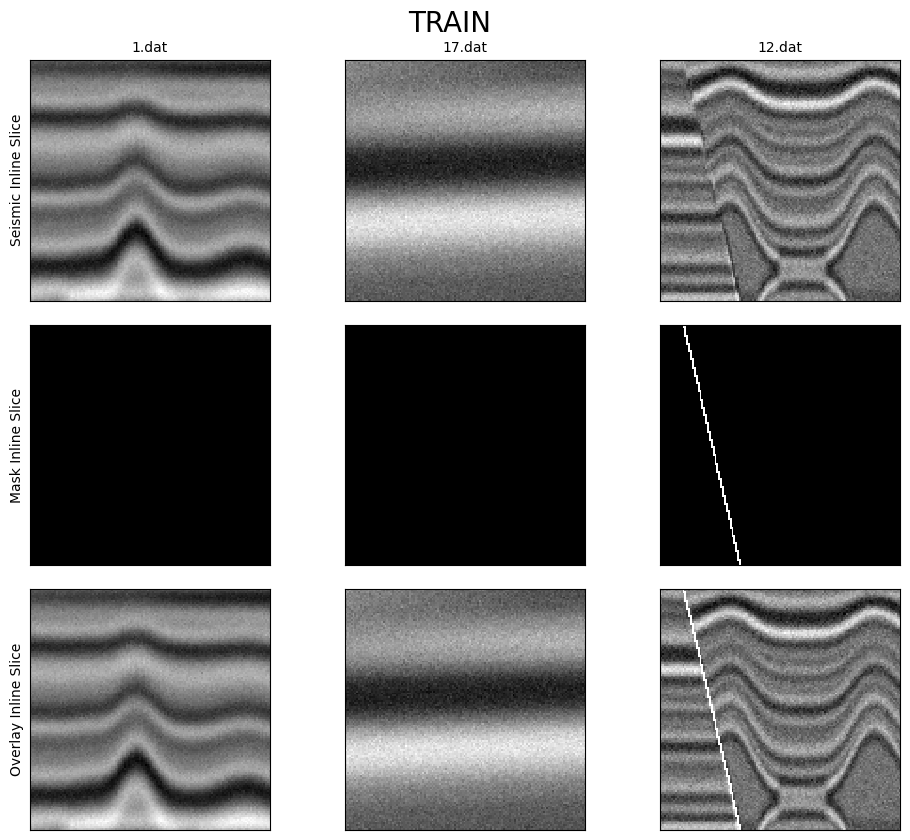

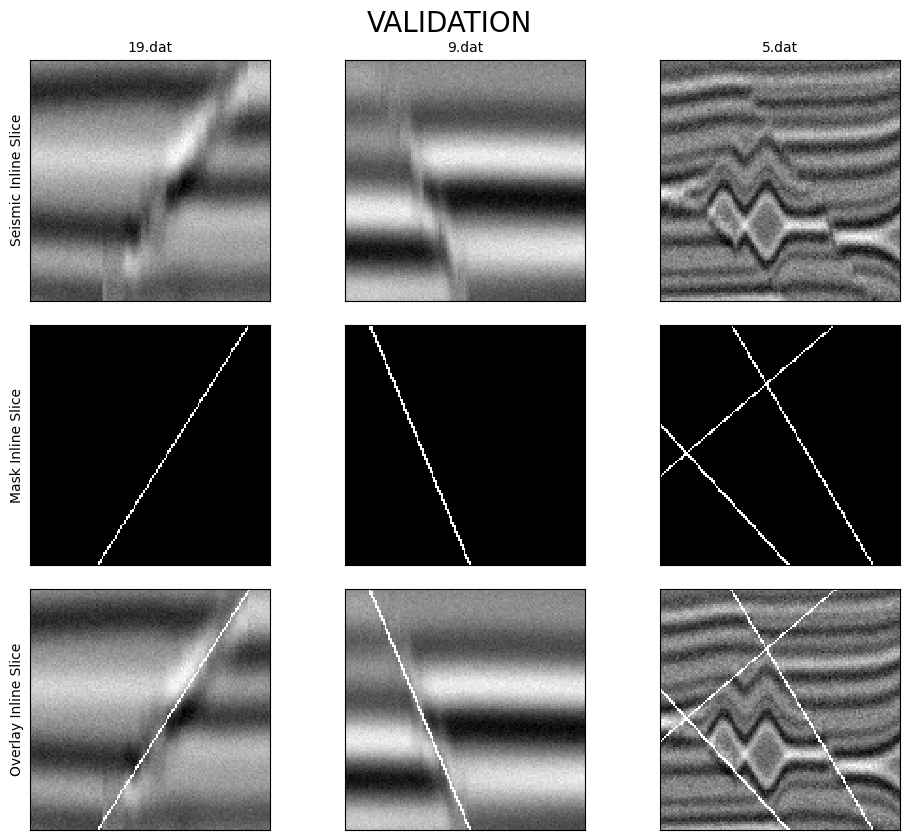

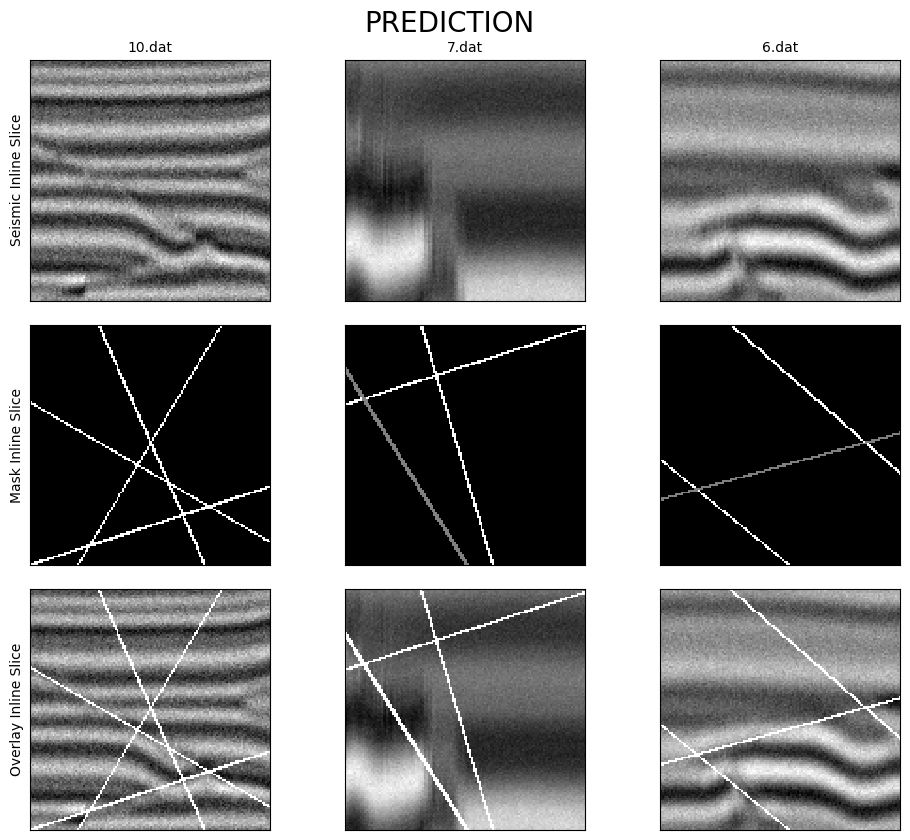

In [12]:
groups = ['train', 'validation', 'prediction']
n_cols = 3  # Always show 3 columns

# Consistent settings
aspect_setting = "equal"
interpolation_setting = "nearest"
origin_setting = "upper"  # Or "lower" if you prefer

for group in groups:
    seis_dir = os.path.join(base_out, group, "seis")
    mask_dir = os.path.join(base_out, group, "fault")
    if not (os.path.exists(seis_dir) and os.path.exists(mask_dir)):
        print(f"Skipping {group}: directories not found.")
        continue

    files = [f for f in os.listdir(seis_dir) if f.endswith(('.dat', '.npy', '.npz'))]
    n_files = len(files)
    if n_files == 0:
        print(f"No files found for {group}.")
        continue

    n_show = min(n_cols, n_files)
    samples = random.sample(files, n_show)

    fig, axes = plt.subplots(
        3, n_cols,
        figsize=(4 * n_cols, 10),
        squeeze=False
    )
    fig.suptitle(
        f"{group.upper()}",
        fontsize=20,
        y=0.93  # Move title closer to images
    )

    for col in range(n_cols):
        if col < n_show:
            fname = samples[col]
            fpath = os.path.join(seis_dir, fname)
            mpath = os.path.join(mask_dir, fname)
            try:
                if fname.endswith(".npy"):
                    s = np.load(fpath)
                    m = np.load(mpath)
                elif fname.endswith(".npz"):
                    s_npz = np.load(fpath)
                    m_npz = np.load(mpath)
                    s = s_npz['arr_0']
                    m = m_npz['arr_0']
                    s_npz.close()
                    m_npz.close()
                else:
                    s = np.fromfile(fpath, dtype=np.float32).reshape((cube_size, cube_size, cube_size))
                    m = np.fromfile(mpath, dtype=np.uint8).reshape((cube_size, cube_size, cube_size))
            except Exception as e:
                print(f"Error loading {fname}: {e}")
                continue

            inline = s[s.shape[0] // 2, :, :].T
            mask_inline = m[m.shape[0] // 2, :, :].T

            vmin, vmax = inline.min(), inline.max()

            # Row 0: seismic
            ax = axes[0, col]
            im1 = ax.imshow(
                inline,
                cmap="gray",
                aspect=aspect_setting,
                interpolation=interpolation_setting,
                origin=origin_setting,
                vmin=vmin,
                vmax=vmax
            )
            ax.set_title(fname, fontsize=10)
            if col == 0:
                ax.set_ylabel("Seismic Inline Slice")
            ax.set_xticks([])
            ax.set_yticks([])

            # Row 1: mask alone
            ax = axes[1, col]
            im2 = ax.imshow(
                mask_inline,
                cmap=mask_alone_cmap_slice,
                aspect=aspect_setting,
                interpolation=interpolation_setting,
                origin=origin_setting
            )
            if col == 0:
                ax.set_ylabel("Mask Inline Slice")
            ax.set_xticks([])
            ax.set_yticks([])

            # Row 2: overlay
            ax = axes[2, col]
            im3 = ax.imshow(
                inline,
                cmap="gray",
                aspect=aspect_setting,
                interpolation=interpolation_setting,
                origin=origin_setting,
                vmin=vmin,
                vmax=vmax
            )
            ax.imshow(
                mask_inline.astype(int),
                cmap=mask_overlay_cmap_slice,
                aspect=aspect_setting,
                interpolation=interpolation_setting,
                origin=origin_setting,
                alpha=overlay_alpha
            )
            if col == 0:
                ax.set_ylabel("Overlay Inline Slice")
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            # Hide unused axes
            for row in range(3):
                axes[row, col].axis('off')

    # Adjust spacing
    plt.subplots_adjust(
        top=0.88,  # Higher makes title closer to plots
        wspace=0.05,
        hspace=0.1  # Less vertical space between rows
    )
    plt.show()

---

---

### 3D Visualization

In [13]:
# PARAMETERS
cube_size = 128  # or whatever you used
mask_mode = 0    # or 1
base_out = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output"

In [14]:
# Function to normalize to 0-255 uint8
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Function to plot fault points
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2),
            name=label
        ))

In [ ]:
# PARAMETERS
cube_size = 128  # Adjust as needed
mask_mode = 0    # 0 = binary masks; 1 = multiclass
base_out = "/Users/roderickperez/Documents/DS_Projects/faultSegm/faultSeg_Wu_2019_Keras/output"

# Normalization helper
def normalize(v):
    return ((v - v.min()) / (v.max() - v.min()) * 255).astype(np.uint8)

# Fault plotting function
def plot_fault_points(fig, slice_mask, axis_index, slice_type, color, label, nx, ny, nz):
    if slice_type == "inline":
        ks, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=np.full_like(ks, axis_index),
            y=js,
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "crossline":
        ks, is_ = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=np.full_like(is_, axis_index),
            z=nz - 1 - ks,
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))
    elif slice_type == "timeslice":
        is_, js = np.where(slice_mask)
        fig.add_trace(go.Scatter3d(
            x=is_,
            y=js,
            z=np.full_like(is_, axis_index),
            mode='markers',
            marker=dict(color=color, size=2, opacity=1),
            name=label
        ))

# Loop over splits
for split in ["train", "validation", "prediction"]:
    seismic_dir = os.path.join(base_out, split, "seis")
    mask_dir = os.path.join(base_out, split, "fault")

    if not (os.path.exists(seismic_dir) and os.path.exists(mask_dir)):
        print(f"[{split}] Skipping: directories not found.")
        continue

    files = sorted(set(os.listdir(seismic_dir)).intersection(os.listdir(mask_dir)))
    if not files:
        print(f"[{split}] No files to visualize.")
        continue

    selected_file = random.choice([f for f in files if f.endswith((".npy", ".dat"))])
    print(f"[{split}] Selected file: {selected_file}")

    # Load data
    seismic_path = os.path.join(seismic_dir, selected_file)
    mask_path = os.path.join(mask_dir, selected_file)

    if selected_file.endswith(".npy"):
        seismic = np.load(seismic_path)
        mask = np.load(mask_path)
    else:
        seismic = np.fromfile(seismic_path, dtype=np.float32).reshape((cube_size, cube_size, cube_size))
        mask = np.fromfile(mask_path, dtype=np.uint8).reshape((cube_size, cube_size, cube_size))

    nx, ny, nz = seismic.shape

    # Slices
    inline     = seismic[nx//2,:,:].T
    crossline  = seismic[:,ny//2,:].T
    timeslice  = seismic[:,:,nz//2]

    inline_m   = mask[nx//2,:,:].T
    cross_m    = mask[:,ny//2,:].T
    timeslice_m= mask[:,:,nz//2]

    inline_norm    = normalize(inline)
    crossline_norm = normalize(crossline)
    timeslice_norm = normalize(timeslice)

    # Create 3D figure
    fig = go.Figure()

    # Seismic surfaces
    fig.add_trace(go.Surface(
        z=np.tile(np.arange(nz)[::-1], (ny, 1)).T,
        x=np.full((nz, ny), nx//2),
        y=np.tile(np.arange(ny), (nz, 1)),
        surfacecolor=inline_norm,
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))
    fig.add_trace(go.Surface(
        z=np.tile(np.arange(nz)[::-1], (nx, 1)).T,
        x=np.tile(np.arange(nx), (nz, 1)),
        y=np.full((nz, nx), ny//2),
        surfacecolor=crossline_norm,
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))
    fig.add_trace(go.Surface(
        z=np.full((ny, nx), nz//2),
        x=np.tile(np.arange(nx), (ny, 1)),
        y=np.tile(np.arange(ny).reshape(-1,1), (1, nx)),
        surfacecolor=np.rot90(timeslice_norm, k=-1),
        colorscale="Gray",
        showscale=False,
        opacity=1
    ))

    # Fault overlays
    if mask_mode == 0:
        plot_fault_points(fig, inline_m==1, nx//2, "inline", "white", "Inline Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==1, ny//2, "crossline", "white", "Crossline Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==1, nz//2, "timeslice", "white", "Time-Slice Faults", nx, ny, nz)
    elif mask_mode == 1:
        plot_fault_points(fig, inline_m==1, nx//2, "inline", "green", "Inline Normal Faults", nx, ny, nz)
        plot_fault_points(fig, inline_m==2, nx//2, "inline", "purple", "Inline Inverse Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==1, ny//2, "crossline", "green", "Crossline Normal Faults", nx, ny, nz)
        plot_fault_points(fig, cross_m==2, ny//2, "crossline", "purple", "Crossline Inverse Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==1, nz//2, "timeslice", "green", "Time-Slice Normal Faults", nx, ny, nz)
        plot_fault_points(fig, timeslice_m==2, nz//2, "timeslice", "purple", "Time-Slice Inverse Faults", nx, ny, nz)

    # Layout
    fig.update_layout(
        title=f"3D Fault Visualization — {split.upper()} / {selected_file}",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode="data"
        ),
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

[train] Selected file: 17.dat


[validation] Selected file: 19.dat


[prediction] Selected file: 6.dat
